In [47]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import optuna
from transformers import AutoTokenizer,AutoModelForSequenceClassification,TrainingArguments,Trainer,pipeline
from datasets import Dataset
import torch
import evaluate 
import matplotlib.pyplot as plt
import sklearn

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [48]:
import json
from pathlib import Path
best_f1 = -float('inf')
best_trial_params = None
best_model_path = "./best-model-final"
model_name = "facebook/bart-base" 


tokenizer = AutoTokenizer.from_pretrained(model_name)
def preprocess(text):
    tokens=tokenizer(list(text['text']),padding='max_length',
                    truncation=True,              # ensure sequences are cut, not just padded
        max_length=128)
    #tokens['labels']=text['labels']
    return tokens


accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    if isinstance(logits, tuple):
        logits = logits[0]

    predictions = np.argmax(logits, axis=-1)

    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")

    return {"accuracy": acc["accuracy"], "F1": f1_score["f1"]}


def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=12,    
        ignore_mismatched_sizes=True       # your number of classes
    )
    model.config.label2id={'aries': 0, 'taurus': 1, 'gemini': 2, 'cancer': 3, 'leo': 4, 'virgo': 5, 'libra': 6, 'scorpio': 7, 'sagittarius': 8, 'capricorn': 9, 'aquarius': 10, 'pisces': 11}
    model.config.id2label={0: 'aries', 1: 'taurus', 2: 'gemini', 3: 'cancer', 4: 'leo', 5: 'virgo', 6: 'libra', 7: 'scorpio', 8: 'sagittarius', 9: 'capricorn', 10: 'aquarius', 11: 'pisces'}
    return(model)



def objective(trial):
    global best_f1, best_trial_params
    lr=trial.suggest_float('learning_rate',1e-5,5e-4,log=True)
    batch_size=trial.suggest_categorical('per_device_train_batch_size',[4,8,16])
    epochs=trial.suggest_int('num_train_epochs',2,6)
    weight_decay=trial.suggest_float('weight_decay',0.0,.1)
    
    training_args = TrainingArguments(
        output_dir=f"./bart-horoscope-optuna",
        eval_strategy="epoch",
        save_strategy="no",              # NEVER auto-save
        save_steps=-1,
        save_total_limit=0,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        logging_steps=100,
        report_to="none",
        load_best_model_at_end=False,
        warmup_ratio=0.1,
        gradient_accumulation_steps=4,
        fp16=True
    )

    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=valid_data,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    predictions = trainer.predict(valid_data)
    eval_metrics = compute_metrics(predictions)
    #eval_metrics = trainer.evaluate()

    if eval_metrics['F1']> best_f1:
        best_f1 = eval_metrics['F1']
        best_trial_params = trial.params.copy()
        
        # Save model + tokenizer
        trainer.save_model(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        
        # Save hyperparameters as JSON
        best_trial_params['best_f1'] = eval_metrics['F1']
        with open(f"{best_model_path}/hyperparams.json", 'w') as f:
            json.dump(best_trial_params, f, indent=2)
    
    
    return eval_metrics['F1']






In [49]:
horoscopes=pd.read_csv('/kaggle/input/horoscopes/horoscope_saved.csv')
signs={'aries': 0, 'taurus': 1, 'gemini': 2, 'cancer': 3, 'leo': 4, 'virgo': 5, 'libra': 6, 'scorpio': 7, 'sagittarius': 8, 'capricorn': 9, 'aquarius': 10, 'pisces': 11}
pattern=', '+'|'.join(['('+s.capitalize()+')' for s in signs])
horoscopes['horoscope']=horoscopes['horoscope'].str.replace(pattern,'',regex=True)
horoscopes['text']='For the date ' +horoscopes['date'].astype(str)+ ' and category '+horoscopes['category']+', what zodiac sign is this?: '+horoscopes['horoscope']
horoscopes['distVar']=horoscopes['sign']+horoscopes['category']
horoscopes['labels']=[signs[s] for s in horoscopes['sign']]
train,test=train_test_split(horoscopes,test_size=.3,random_state=69,stratify=horoscopes['distVar'])
valid,test=train_test_split(test,test_size=.5,random_state=69,stratify=test['distVar'])

train_data=Dataset.from_pandas(train[['text','labels']]).map(preprocess,batched=True)
train_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
train_data=train_data.remove_columns("__index_level_0__")
valid_data=Dataset.from_pandas(valid[['text','labels']]).map(preprocess,batched=True)
valid_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
valid_data=valid_data.remove_columns("__index_level_0__")
test_data=Dataset.from_pandas(test[['text','labels']])
test_data.map(preprocess,batched=True).set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_data=test_data.remove_columns("__index_level_0__")

Map:   0%|          | 0/15371 [00:00<?, ? examples/s]

Map:   0%|          | 0/3294 [00:00<?, ? examples/s]

Map:   0%|          | 0/3294 [00:00<?, ? examples/s]

In [7]:
train_data

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 15371
})

In [22]:
#this is completely for testing if set up is correct 

from datasets import load_dataset
dataset = load_dataset("ag_news")
train_data = dataset["train"].rename_column("label", "labels")
valid_data = dataset["test"].rename_column("label", "labels")
train_data = train_data.select(range(12000))  # 12k samples
valid_data = valid_data.select(range(760))  
#train_data
train_data=train_data.map(preprocess,batched=True)
train_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
valid_data=valid_data.map(preprocess,batched=True)
valid_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
#test_data=Dataset.from_pandas(test[['text','label']])
#test_data.map(preprocess,batched=True).set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/760 [00:00<?, ? examples/s]

In [66]:
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=10)

[I 2025-12-29 22:12:56,649] A new study created in memory with name: no-name-d91a9128-8b89-467f-95c1-8a0ac94f3652
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [52]:
best_model=pipeline(task="text-classification",model=best_model_path)
results=best_model(list(test['text']),batch_size=32)

You passed `num_labels=3` which is incompatible to the `id2label` map of length `12`.
You passed `num_labels=3` which is incompatible to the `id2label` map of length `12`.
Device set to use cuda:0


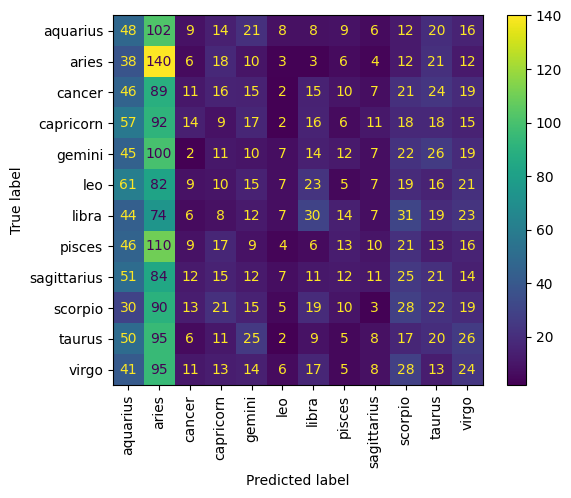

In [65]:
test['pred']=[r['label'] for r in results]
labels = sorted(pd.unique(test[['sign','pred']].values.ravel()))
cm = metrics.confusion_matrix(test['sign'], test['pred'], labels=labels)
cmPlot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
cmPlot.plot(xticks_rotation=90)

The model learned to only predict two classes, aquaries and aries. This maybe why there trial had the best model. Although it is a degenerate solution